In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.fftpack import fft, rfft
from scipy import signal
import librosa

# Generate test data
sr = 44100
freq = 100
x = librosa.tone(freq, sr=sr, length=sr)
x2 = librosa.tone(2*freq, sr=sr, length=sr) * 0.01
x += x2

# Read signal from file
x, sr = librosa.load('fiifo_adcom_xfi_1kHz.wav') #'Sony_DVP_to_xfi_1kHz.wav'

# Get zero-crossings
zc = np.where(np.diff(np.sign(x)))[0]

# Remove the last zero-crossing, if necessary, to span an integer number of cycles
if len(zc) % 2 == 0:
    zc = zc[:-1]
    
# Calculate the signal frequency from the zero-crossings
nzc = len(zc)
freq = 0.5 * (nzc - 1) / ( zc[-1] - zc[0] ) * sr

print(f'Samples        = {len(x)}')
print(f'Sampling rate  = {sr} Hz')
print(f'Zero-crossings = {nzc}')
print(f'Frequency      = {freq:.3f} Hz')

e:\apps\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Samples        = 228638
Sampling rate  = 22050 Hz
Zero-crossings = 20739
Frequency      = 1000.006 Hz


In [2]:
# Trucnate x to an integer number of cycles
x = x[zc[0]:zc[-1]]
print(f'Samples = {len(x)}')

Samples = 228635


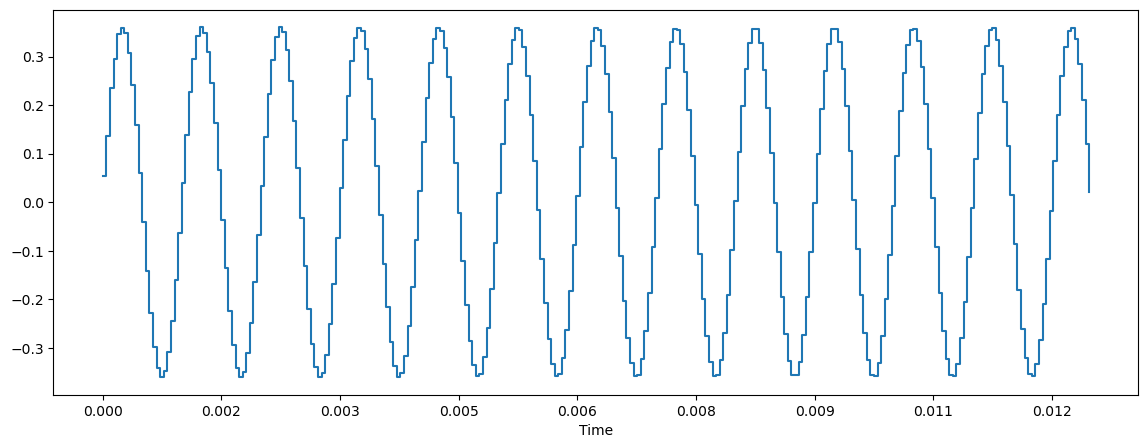

In [3]:
#%matplotlib inline
#import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(14, 5))
librosa.display.waveshow(x[zc[0]:zc[25]], sr=sr)

<StemContainer object of 3 artists>

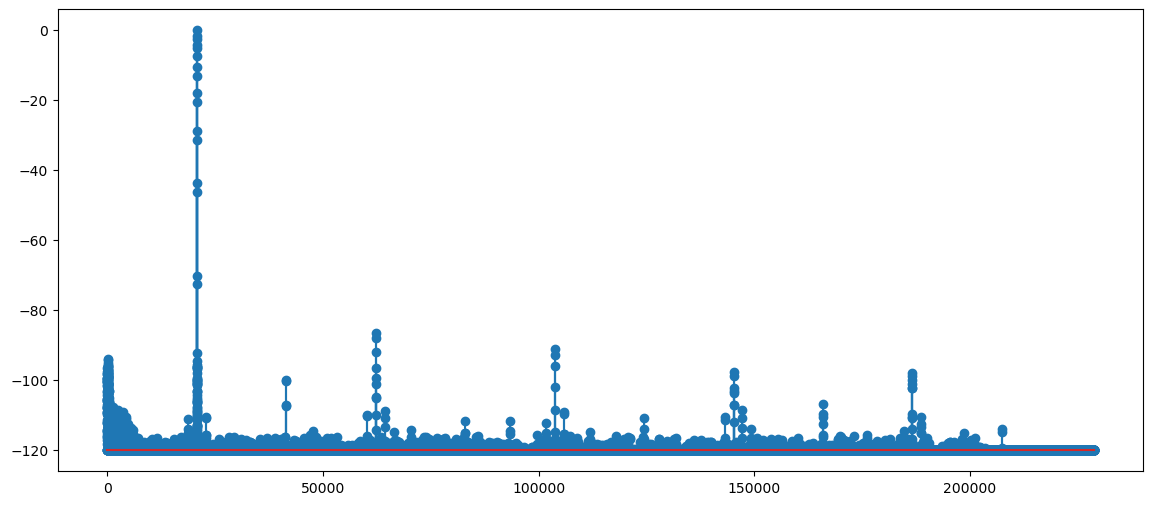

In [4]:
# compute FFT
tol = 8

w = signal.windows.blackmanharris(len(x))
xw = x*w
yf = rfft(xw)
pwr = yf*yf.conjugate()
db = librosa.power_to_db(pwr, top_db=120)
db -= db.max()

plt.figure(figsize=(14, 6))
plt.stem(db, bottom=-120)


In [5]:
idx = np.nonzero(db > -100.0)
print(idx)
print(db[idx])

(array([    19,     24,     26,     30,     32,     34,     46,     48,
           49,     50,     53,     55,     66,     72,     74,     75,
           76,     77,     78,     80,     82,     91,     92,     94,
           99,    101,    102,    104,    106,    108,    120,    122,
          124,    126,    128,    152,    154,    218,    220,  20715,
        20719,  20721,  20722,  20723,  20725,  20726,  20727,  20728,
        20729,  20730,  20731,  20732,  20733,  20734,  20735,  20736,
        20737,  20738,  20739,  20740,  20741,  20742,  20743,  20744,
        20751,  20752,  20755,  62210,  62211,  62212,  62214,  62216,
       103685, 103687, 103689, 145162, 145164, 186635, 186637, 186638],
      dtype=int64),)
[-99.31915064 -99.70497565 -99.4917364  -99.77625274 -98.20724995
 -97.7401347  -98.10718792 -96.47847673 -98.90920656 -98.93426243
 -99.61688842 -99.40097882 -99.83706024 -97.903321   -93.86300572
 -98.11453613 -94.29987416 -97.62971053 -96.11654115 -95.55719752
 -9

In [6]:
fund = int(np.nonzero(db == 0.0)[0])

# Alternate method:
#zc = np.where(np.diff(np.sign(x)))[0]
#fund = len(zc)

[-106.03874       0.         -101.36546842  -88.2375335  -112.87425807
  -92.97315858 -112.95834781  -98.14337116 -107.77765251  -97.25767271
 -115.34146734]


<StemContainer object of 3 artists>

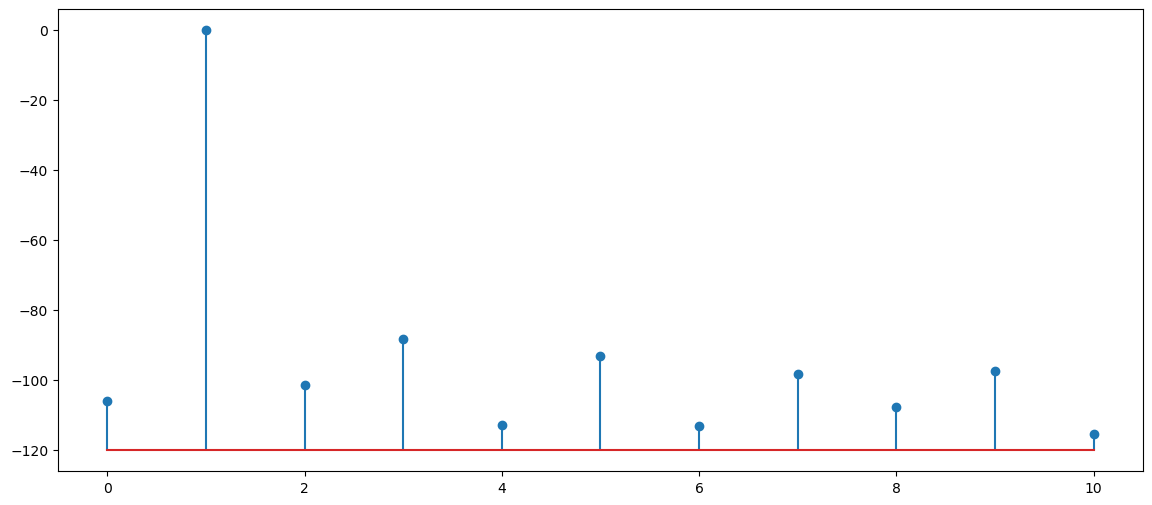

In [7]:
# Calculate power of signal, harmonics, and noise
signal_pwr = 0.0
noise_pwr = 0.0
harm_pwr = []
n = 0
for i in range(len(pwr)):
    if i >= (n*fund - tol) and i <= (n*fund + tol):
        signal_pwr += pwr[i]
    else:
        noise_pwr += pwr[i]
    if i > (n+0.5)*fund:
        harm_pwr.append(signal_pwr)
        signal_pwr = 0.0
        n += 1
        
noise_pwr /= harm_pwr[1]
harm_pwr /= harm_pwr[1]

harm_db = 10*np.log10(harm_pwr)
print(harm_db)

plt.figure(figsize=(14, 6))
plt.stem(harm_db, bottom=-120)

In [8]:
freq = fund / len(w) / 2.0 * sr

dist_pwr = sum(harm_pwr[2:])
fund_pwr = harm_pwr[1]
dc_pwr = harm_pwr[0]
sfdr_pwr = max(harm_pwr[2:])

snr = 10*math.log10(noise_pwr / fund_pwr)
sfdr = 10*math.log10(sfdr_pwr / fund_pwr)
sinad = 10*math.log10((noise_pwr + dist_pwr) / fund_pwr)
thd = math.sqrt(dist_pwr/fund_pwr)
thd_pct = thd*100.0
thd_db = 20*math.log10(thd)

print('Statistics')
print('-----------------------')
print(f'Samples = {len(x)}')
print(f'Min     = {min(x):6.3f}')
print(f'Max     = {max(x):6.3f}')
print(f'Freq    = {freq:.3f} Hz')
print(f'SNR     = {snr:3.1f} dB')
print(f'SFDR    = {sfdr:3.1f} dB')
print(f'SINAD   = {sinad:3.1f} dB')
print(f'THD     = {thd_db:3.1f} dB')
print(f'THD     = {thd_pct:.3f}%')

Statistics
-----------------------
Samples = 228635
Min     = -0.361
Max     =  0.361
Freq    = 999.958 Hz
SNR     = -81.1 dB
SFDR    = -88.2 dB
SINAD   = -79.9 dB
THD     = -86.1 dB
THD     = 0.005%
